In [3]:
import csv

In [35]:
import csv
from datetime import datetime, timedelta
from collections import defaultdict
# ------------------------------
# Monthly Temperature Thresholds
# ------------------------------
MONTHLY_THRESHOLDS = {
    # Format: Month (1-12): (AC_THRESHOLD, FAN_THRESHOLD)
    1: (35, 28),   # January (cooler)
    2: (35, 28),
    3: (38, 31),
    4: (40, 31),   # April (summer)
    5: (38, 31),
    6: (37, 30),
    7: (36, 29),
    8: (36, 29),
    9: (35, 28),
    10: (34, 27),
    11: (34, 27),
    12: (35, 28)
}
# ------------------------------
# Global Parameters
# ------------------------------
ALLOW_FRIDGE_SHUTDOWN = False  # Not used since fridge is always on
MAX_FRIDGE_OFF_HOURS = 0       # Not used since fridge is always on
BUDGET =    2000.0                # Increased budget for this example
MAX_CONTINUOUS_AC_HOURS = 4
AC_REST_PERIOD = 2

# ------------------------------
# Baseline and Usage Requirements
# ------------------------------
baseline_hours = {
    "Refrigerator": 720,       # 24/7 for 30 days (24*30)
    "Air Conditioner": 20,
    "Fans": 120,
    "Lights": 180,
    "Television": 1
}
max_hours_per_day = {
    "Air Conditioner": 8,
    "Fans": 12,
    "Lights": 8,
    "Television": 3
}
minimum_usage_hours = {
    "Air Conditioner": 20,
    "Lights": 50,
    "Fans": 50,
    "Television": 1
}


# ------------------------------
# Appliance Configurations & Priorities
# ------------------------------
appliance_consumption = {
    "Refrigerator": 0.10,
    "Air Conditioner": 1.2,
    "Lights": 0.15,
    "Fans": 0.24,        # 0.24 kWh/hr here reflects 3 fans (each 0.08 kWh/hr)
    "Television": 0.1
}
removal_order = ["Air Conditioner", "Television", "Fans", "Lights", "Refrigerator"]
addition_order = ["Refrigerator", "Fans", "Lights", "Air Conditioner", "Television"]
appliance_priority = {
    "Refrigerator": 1,
    "Fans": 1,
    "Lights": 1,
    "Air Conditioner": 2,
    "Television": 2
}

# ------------------------------
# CSV Parsing
# ------------------------------
def parse_forecast_from_csv(csv_filename):
    forecast = {}
    try:
        with open(csv_filename, 'r', newline='', encoding='utf-8') as csvfile:
            reader = csv.reader(csvfile)
            next(reader)  # Skip header
            for row in reader:
                if len(row) < 2:
                    continue
                try:
                    dt = datetime.strptime(row[0].strip(), "%Y-%m-%d %H:%M:%S")
                    forecast[dt] = float(row[1].strip())
                except (ValueError, IndexError):
                    continue
    except FileNotFoundError:
        print(f"Error: File {csv_filename} not found.")
    return forecast

# ------------------------------
# Cost Calculation
# ------------------------------
def compute_cost(total_kwh):
    slabs = [(30, 1.90), (45, 3.00), (50, 4.50), (100, 6.00), (175, 8.75), (float('inf'), 9.75)]
    cost, remaining = 0.0, total_kwh
    for slab_units, rate in slabs:
        if remaining <= 0:
            break
        units = min(remaining, slab_units)
        cost += units * rate
        remaining -= units
    return cost

# ------------------------------
# Consumption and Usage Helpers
# ------------------------------
def compute_monthly_consumption(schedule):
    return sum(sum(appliance_consumption.get(app, 0) for app in apps)
               for apps in schedule.values())

def get_usage_by_day(schedule, appliance):
    usage = defaultdict(int)
    for dt_str, apps in schedule.items():
        if appliance in apps:
            usage[dt_str.split()[0]] += 1
    return usage

# ------------------------------
# Schedule Generation
# ------------------------------
def generate_initial_schedule(temp_forecast):
    schedule, forced_ac_hours = {}, set()
    temp_str = {dt.strftime("%Y-%m-%d %H:%M"): temp for dt, temp in temp_forecast.items()}
    sorted_temps = sorted(((dt.strftime("%Y-%m-%d %H:%M"), temp)
                           for dt, temp in temp_forecast.items()),
                          key=lambda x: x[1], reverse=True)
    ac_hours_needed = min(baseline_hours["Air Conditioner"], len(sorted_temps))
    hottest_hour_dts = {dt for dt, _ in sorted_temps[:ac_hours_needed]}
    min_ac_temp = sorted_temps[ac_hours_needed-1][1] if ac_hours_needed > 0 else AC_TEMP_THRESHOLD
    hourly_ac_tracking = defaultdict(list)
    all_dts = sorted(temp_forecast.keys())
    ac_continuous_hours = ac_off_hours = 0
    last_dt = None

    for dt in all_dts:
        dt_str = dt.strftime("%Y-%m-%d %H:%M")
        date_str = dt.strftime("%Y-%m-%d")
        hour = dt.hour
        temp = temp_forecast[dt]
        if last_dt and dt - last_dt == timedelta(hours=1):
            if ac_continuous_hours >= MAX_CONTINUOUS_AC_HOURS:
                ac_off_hours += 1
                use_ac = ac_off_hours >= AC_REST_PERIOD and (temp >= AC_TEMP_THRESHOLD or dt_str in hottest_hour_dts)
                if use_ac:
                    ac_continuous_hours, ac_off_hours = 1, 0
            else:
                use_ac = temp >= AC_TEMP_THRESHOLD or dt_str in hottest_hour_dts
                if use_ac:
                    ac_continuous_hours, ac_off_hours = ac_continuous_hours + 1, 0
                else:
                    ac_off_hours += 1
        else:
            use_ac = temp >= AC_TEMP_THRESHOLD or dt_str in hottest_hour_dts
            ac_continuous_hours, ac_off_hours = (1, 0) if use_ac else (0, 1)

        if use_ac and len(hourly_ac_tracking[date_str]) < max_hours_per_day["Air Conditioner"]:
            apps = ["Refrigerator", "Air Conditioner"]
            hourly_ac_tracking[date_str].append(hour)
            if temp >= AC_TEMP_THRESHOLD:
                forced_ac_hours.add(dt_str)
        else:
            apps = ["Refrigerator"]
            if FAN_TEMP_THRESHOLD <= temp < min_ac_temp:
                apps.append("Fans")
        if 18 <= hour <= 23:
            apps.append("Lights")
        if 20 <= hour <= 22:
            apps.append("Television")
        schedule[dt_str] = apps
        last_dt = dt
    return schedule, forced_ac_hours

# ------------------------------
# Enforce Baseline Usage
# ------------------------------
def enforce_baseline(schedule, baseline, forced_ac_hours, temp_forecast):
    for dt_str, apps in schedule.items():
        if "Refrigerator" not in apps:
            apps.append("Refrigerator")
    current_usage = {app: 0 for app in appliance_consumption}
    for dt_str, apps in schedule.items():
        for app in appliance_consumption:
            if app in apps:
                current_usage[app] += 1

    for app, req in baseline.items():
        if app == "Refrigerator" or current_usage[app] >= req:
            continue
        needed = req - current_usage[app]
        if app == "Air Conditioner":
            dt_temp_pairs = []
            daily_usage = get_usage_by_day(schedule, app)
            for dt_str, apps in schedule.items():
                if app not in apps:
                    dt_obj = datetime.strptime(dt_str, "%Y-%m-%d %H:%M")
                    day = dt_str.split()[0]
                    if daily_usage.get(day, 0) < max_hours_per_day[app]:
                        try:
                            temp = temp_forecast[dt_obj]
                            dt_temp_pairs.append((dt_str, day, temp))
                        except KeyError:
                            continue
            dt_temp_pairs.sort(key=lambda x: x[2], reverse=True)
            for dt_str, day, _ in dt_temp_pairs[:needed]:
                if daily_usage.get(day, 0) < max_hours_per_day[app]:
                    schedule[dt_str].append(app)
                    if "Fans" in schedule[dt_str]:
                        schedule[dt_str].remove("Fans")
                    daily_usage[day] += 1
                    needed -= 1
                    if needed == 0:
                        break
        elif app == "Fans":
            dt_temp_pairs = []
            daily_usage = get_usage_by_day(schedule, app)
            for dt_str, apps in schedule.items():
                if app not in apps and "Air Conditioner" not in apps:
                    dt_obj = datetime.strptime(dt_str, "%Y-%m-%d %H:%M")
                    day = dt_str.split()[0]
                    if daily_usage.get(day, 0) < max_hours_per_day[app]:
                        try:
                            temp = temp_forecast[dt_obj]
                            dt_temp_pairs.append((dt_str, day, abs(temp - FAN_TEMP_THRESHOLD)))
                        except KeyError:
                            continue
            dt_temp_pairs.sort(key=lambda x: x[2])
            for dt_str, day, _ in dt_temp_pairs[:needed]:
                if daily_usage.get(day, 0) < max_hours_per_day[app]:
                    schedule[dt_str].append(app)
                    daily_usage[day] += 1
                    needed -= 1
                    if needed == 0:
                        break
        else:
            daily_usage = get_usage_by_day(schedule, app)
            for dt_str in sorted(schedule.keys()):
                if app not in schedule[dt_str]:
                    day = dt_str.split()[0]
                    if daily_usage.get(day, 0) < max_hours_per_day.get(app, 24):
                        schedule[dt_str].append(app)
                        daily_usage[day] += 1
                        needed -= 1
                        if needed == 0:
                            break
    return schedule

# ------------------------------
# Distribute Extra Budget Evenly Across Days
# ------------------------------
def distribute_extra_budget(schedule, budget):
    """
    Iterates in a round-robin fashion over days and time slots.
    For each day, for each appliance (in addition_order) that is below its maximum hours,
    tries to add one extra hour if it doesn't cause the total cost to exceed the budget.
    """
    current_cost = compute_cost(compute_monthly_consumption(schedule))
    days = sorted({dt.split()[0] for dt in schedule})
    
    while current_cost < budget:
        change_made = False
        for day in days:
            day_slots = sorted(dt for dt in schedule if dt.split()[0] == day)
            for app in addition_order:
                day_usage = sum(1 for dt in day_slots if app in schedule[dt])
                if day_usage >= max_hours_per_day.get(app, 24):
                    continue
                for dt in day_slots:
                    if app not in schedule[dt]:
                        schedule[dt].append(app)
                        new_cost = compute_cost(compute_monthly_consumption(schedule))
                        if new_cost > budget:
                            schedule[dt].remove(app)
                        else:
                            change_made = True
                        break
        if not change_made:
            break
        current_cost = compute_cost(compute_monthly_consumption(schedule))
    return schedule

# ------------------------------
# Adjust Schedule by Budget Evenly (Day-Based Removal/Addition)
# ------------------------------
def adjust_schedule_by_budget_even(schedule, forced_ac_hours, budget):
    """
    If the current cost exceeds the budget, removes extra hours evenly across days.
    If the cost is below budget, extra hours are distributed evenly among days.
    The Refrigerator is never removed.
    """
    adjusted = {dt: list(apps) for dt, apps in schedule.items()}
    current_cost = compute_cost(compute_monthly_consumption(adjusted))
    
    if current_cost > budget:
        daily_minimum = {"Lights": 1}  # Each day must have at least 1 hour of Lights
        while current_cost > budget:
            days = sorted({dt.split()[0] for dt in adjusted})
            removal_made = False
            for day in days:
                day_slots = sorted(dt for dt in adjusted if dt.split()[0] == day)
                for dt in day_slots:
                    for app in removal_order:
                        if app not in adjusted[dt]:
                            continue
                        if dt in forced_ac_hours and app == "Air Conditioner":
                            continue
                        if app == "Refrigerator":
                            continue
                        if app in daily_minimum:
                            day_usage = sum(1 for d, apps in adjusted.items() if d.split()[0] == day and app in apps)
                            if day_usage <= daily_minimum[app]:
                                continue
                        adjusted[dt].remove(app)
                        removal_made = True
                        new_cost = compute_cost(compute_monthly_consumption(adjusted))
                        if new_cost <= budget:
                            return adjusted
                        break
                    if removal_made:
                        break
                if removal_made:
                    break
            if not removal_made:
                break
            current_cost = compute_cost(compute_monthly_consumption(adjusted))
        return adjusted
    elif current_cost < budget:
        adjusted = distribute_extra_budget(adjusted, budget)
        return adjusted
    else:
        return adjusted

# ------------------------------
# CSV Output for Final Schedule
# ------------------------------
def save_schedule_to_csv(schedule, filename="final_schedule.csv"):
    appliances = list(appliance_consumption.keys())
    try:
        with open(filename, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["Datetime"] + appliances)
            for dt, apps in sorted(schedule.items()):
                writer.writerow([dt] + ["ON" if app in apps else "OFF" for app in appliances])
        return True
    except Exception as e:
        print(f"Error saving schedule to CSV: {e}")
        return False

# ------------------------------
# CSV Output for Day Summary (with Temperature Range)
# ------------------------------
def save_day_summary_to_csv(schedule, temp_forecast, filename="day_summary.csv"):
    """
    Aggregates each day’s appliance ON hours and adds daily minimum and maximum temperature.
    Writes a summary CSV with columns: Date, per-appliance ON hours, Min Temp, Max Temp.
    """
    # Aggregate schedule info per day
    day_summary = defaultdict(lambda: {app: 0 for app in appliance_consumption})
    for dt_str, apps in schedule.items():
        day = dt_str.split()[0]
        for app in apps:
            day_summary[day][app] += 1  # Each occurrence counts as 1 hour

    # Compute daily temperature min and max from forecast
    daily_temps = defaultdict(list)
    for dt, temp in temp_forecast.items():
        day = dt.strftime("%Y-%m-%d")
        daily_temps[day].append(temp)
    
    header = ["Date"] + list(appliance_consumption.keys()) + ["Min Temp", "Max Temp"]
    try:
        with open(filename, "w", newline="") as file:
            writer = csv.writer(file)
            writer.writerow(header)
            for day in sorted(day_summary.keys()):
                min_temp = min(daily_temps[day]) if daily_temps[day] else ""
                max_temp = max(daily_temps[day]) if daily_temps[day] else ""
                row = [day] + [day_summary[day][app] for app in appliance_consumption] + [min_temp, max_temp]
                writer.writerow(row)
        return True
    except Exception as e:
        print(f"Error saving day summary to CSV: {e}")
        return False

# ------------------------------
# Analysis
# ------------------------------
def analyze_appliance_distribution(schedule, temp_forecast):
    usage_stats = {app: {"total_hours": 0, "daily_hours": defaultdict(int), "temps": []}
                   for app in appliance_consumption}
    temp_str = {dt.strftime("%Y-%m-%d %H:%M"): temp for dt, temp in temp_forecast.items()}
    continuous_ac = defaultdict(list)
    for dt_str, apps in sorted(schedule.items()):
        day = dt_str.split()[0]
        hour = int(dt_str.split()[1].split(":")[0])
        for app in apps:
            usage_stats[app]["total_hours"] += 1
            usage_stats[app]["daily_hours"][day] += 1
            if dt_str in temp_str and app in ["Air Conditioner", "Fans"]:
                usage_stats[app]["temps"].append(temp_str[dt_str])
        if "Air Conditioner" in apps:
            continuous_ac[day].append(hour)
    result = {}
    for app, data in usage_stats.items():
        app_key = app.lower().replace(" ", "")
        if app == "Refrigerator":
            app_key = "fridge"
        elif app == "Air Conditioner":
            app_key = "ac"
        daily = data["daily_hours"]
        days_used = sum(1 for hours in daily.values() if hours > 0)
        avg_hours = data["total_hours"] / len(daily) if daily else 0
        result[app_key] = {
            "total_hours": data["total_hours"],
            "days_used": days_used,
            "max_hours_per_day": max(daily.values()) if daily else 0,
            "avg_hours_per_day": avg_hours,
            "daily_hours": dict(daily)
        }
        if app in ["Air Conditioner", "Fans"] and data["temps"]:
            temps = data["temps"]
            result[app_key].update({
                "avg_temp": sum(temps) / len(temps),
                "min_temp": min(temps),
                "max_temp": max(temps)
            })
    max_continuous_ac = 0
    for day, hrs in continuous_ac.items():
        hrs.sort()
        streak = 1
        max_streak = 1
        for i in range(1, len(hrs)):
            streak = streak + 1 if hrs[i] == hrs[i-1] + 1 else 1
            max_streak = max(max_streak, streak)
        max_continuous_ac = max(max_continuous_ac, max_streak)
    if "ac" in result:
        result["ac"]["max_continuous_hours"] = max_continuous_ac
    return result

# ------------------------------
# Main Function
# ------------------------------
def main():
    global AC_TEMP_THRESHOLD, FAN_TEMP_THRESHOLD 
    temp_forecast = parse_forecast_from_csv("temperature_data.csv")
    if not temp_forecast:
        print("Error: No temperature data available from CSV.")
        return
    first_dt = next(iter(temp_forecast.keys()))  # Get first datetime entry
    current_month = first_dt.month

    # Update thresholds based on the month
    AC_TEMP_THRESHOLD, FAN_TEMP_THRESHOLD = MONTHLY_THRESHOLDS.get(
        current_month, (38, 31)  # Default to April thresholds
    )
    schedule, forced_ac_hours = generate_initial_schedule(temp_forecast)
    schedule = enforce_baseline(schedule, baseline_hours, forced_ac_hours, temp_forecast)
    final_schedule = adjust_schedule_by_budget_even(schedule, forced_ac_hours, BUDGET)
    
    if save_schedule_to_csv(final_schedule):
        print("Schedule saved to final_schedule.csv")
    if save_day_summary_to_csv(final_schedule, temp_forecast):
        print("Day summary saved to day_summary.csv")
    
    unique_days = len({dt.split()[0] for dt in final_schedule})
    total_consumption = compute_monthly_consumption(final_schedule)
    total_cost = compute_cost(total_consumption)
    on_hours = {app: sum(1 for apps in final_schedule.values() if app in apps)
                for app in appliance_consumption}
    
    analysis = analyze_appliance_distribution(final_schedule, temp_forecast)
    
    print("\n--- FINAL REPORT ---")
    print(f"Budget Given: ₹{BUDGET:.2f}")
    print(f"Budget Used: ₹{total_cost:.2f}")
    print(f"Total Energy Consumption: {total_consumption:.2f} kWh")
    print("\nNumber of 'ON' Hours per Appliance:")
    for app, hours in on_hours.items():
        avg_per_day = hours / unique_days if unique_days else 0
        print(f"  {app}: {hours} hours (avg: {avg_per_day:.1f} hours/day)")
    
    for app_key, stats in analysis.items():
        app_name = "Refrigerator" if app_key == "fridge" else "Air Conditioner" if app_key == "ac" else app_key.capitalize()
        print(f"\n{app_name} Usage:")
        print(f"  Total Hours: {stats['total_hours']}")
        print(f"  Days with Usage: {stats['days_used']}")
        print(f"  Maximum Hours per Day: {stats['max_hours_per_day']}")
        print(f"  Average Hours per Day: {stats['avg_hours_per_day']:.1f}")
        if 'avg_temp' in stats:
            print(f"  Temperature Range: {stats['min_temp']:.1f}°C - {stats['max_temp']:.1f}°C")
            print(f"  Average Temperature: {stats['avg_temp']:.1f}°C")
        if app_key == "ac" and 'max_continuous_hours' in stats:
            print(f"  Maximum Continuous Hours: {stats['max_continuous_hours']}")
    
    fridge_off_count = sum(1 for apps in final_schedule.values() if "Refrigerator" not in apps)
    if fridge_off_count:
        print(f"\nWARNING: Refrigerator is scheduled OFF for {fridge_off_count} hours!")
    else:
        print("\nConfirmed: Refrigerator is ON for all hours as requested.")
    
    print("\nEnergy Cost Distribution:")
    for app in appliance_consumption:
        app_schedule = {dt: [a for a in apps if a == app] for dt, apps in final_schedule.items()}
        app_energy = compute_monthly_consumption(app_schedule)
        app_percentage = (app_energy / total_consumption) * 100 if total_consumption else 0
        app_cost = (app_energy / total_consumption) * total_cost if total_consumption else 0
        print(f"  {app}: {app_energy:.2f} kWh ({app_percentage:.1f}%) - ₹{app_cost:.2f}")

if __name__ == "__main__":
    main()

Schedule saved to final_schedule.csv
Day summary saved to day_summary.csv

--- FINAL REPORT ---
Budget Given: ₹2000.00
Budget Used: ₹1999.80
Total Energy Consumption: 337.32 kWh

Number of 'ON' Hours per Appliance:
  Refrigerator: 720 hours (avg: 24.0 hours/day)
  Air Conditioner: 112 hours (avg: 3.7 hours/day)
  Lights: 240 hours (avg: 8.0 hours/day)
  Fans: 358 hours (avg: 11.9 hours/day)
  Television: 90 hours (avg: 3.0 hours/day)

Refrigerator Usage:
  Total Hours: 720
  Days with Usage: 30
  Maximum Hours per Day: 24
  Average Hours per Day: 24.0

Air Conditioner Usage:
  Total Hours: 112
  Days with Usage: 30
  Maximum Hours per Day: 6
  Average Hours per Day: 3.7
  Temperature Range: 25.4°C - 40.6°C
  Average Temperature: 30.3°C
  Maximum Continuous Hours: 3

Lights Usage:
  Total Hours: 240
  Days with Usage: 30
  Maximum Hours per Day: 8
  Average Hours per Day: 8.0

Fans Usage:
  Total Hours: 358
  Days with Usage: 30
  Maximum Hours per Day: 12
  Average Hours per Day: 11.9


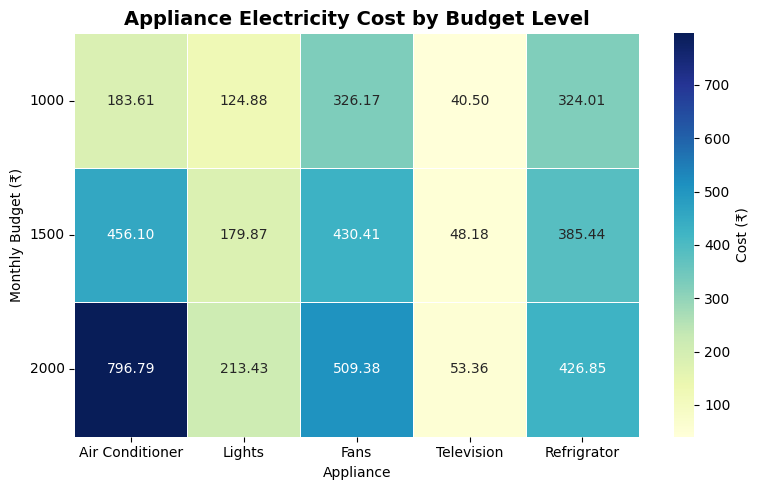

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Define the data manually from screenshots
data = {
    'Budget': [1000, 1500, 2000],
    'Air Conditioner': [183.61, 456.10, 796.79],
    'Lights': [124.88, 179.87, 213.43],
    'Fans': [326.17, 430.41, 509.38],
    'Television': [40.50, 48.18, 53.36],
    'Refrigrator':[324.01,385.44,426.85]
}

# Step 2: Create a DataFrame for plotting
df = pd.DataFrame(data)
df.set_index('Budget', inplace=True)

# Step 3: Plot the heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(df, annot=True, fmt='.2f', cmap='YlGnBu', linewidths=0.5,
            cbar_kws={'label': 'Cost (₹)'}, annot_kws={"size": 10})

plt.title('Appliance Electricity Cost by Budget Level', fontsize=14, fontweight='bold')
plt.xlabel('Appliance')
plt.ylabel('Monthly Budget (₹)')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

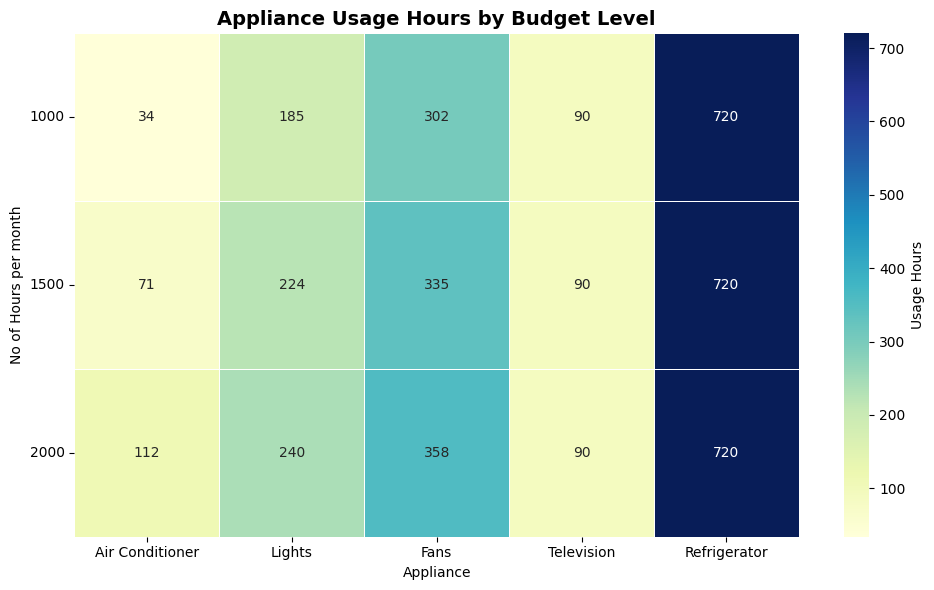

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data: Budget vs Usage Hours for each appliance
data = {
    'Budget (₹)': [1000, 1500, 2000],
    'Air Conditioner': [34, 71, 112],    # Hours at ₹1000, ₹1500, ₹2000 budgets
    'Lights': [185, 224, 240],
    'Fans': [302, 335 , 358],
    'Television': [90, 90, 90],
    'Refrigerator': [720, 720, 720]       # Always on 24/7
}

# Create DataFrame
df = pd.DataFrame(data)
df.set_index('Budget (₹)', inplace=True)

# Plot heatmap
plt.figure(figsize=(10, 6))
ax = sns.heatmap(df, 
                 annot=True, 
                 fmt='d',          # Integer format for hours
                 cmap='YlGnBu',    # Yellow-Green-Blue colormap
                 linewidths=0.5,
                 cbar_kws={'label': 'Usage Hours'},
                 annot_kws={"size": 10})

plt.title('Appliance Usage Hours by Budget Level', 
          fontsize=14, fontweight='bold')
plt.xlabel('Appliance')
plt.ylabel('No of Hours per month')
plt.yticks(rotation=0)

# Adjust layout to prevent cutoff
plt.tight_layout()
plt.show()